# Reward shaping analysis

In [1]:
import sys
from pathlib import Path

# Modify this as you wish, used for importing custom project packages, such as `utils`
project_path = str(Path.home()) + "\\Projects\\rlgym_demo"

sys.path.insert(0, project_path)

In [2]:
import numpy as np
from rlgym.utils import common_values
from utils.analysis.reward_functions import common, extra
from utils.analysis import plotting

## Common rewards

### Ball2Goal

In [3]:
arena_positions = plotting.arena_positions

#### Distance to goal

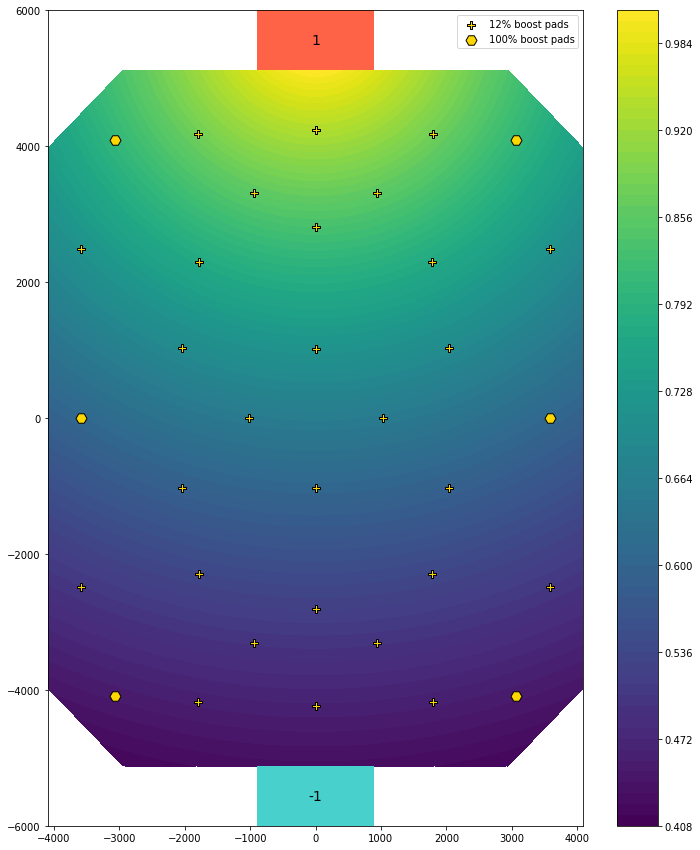

In [4]:
ball_zs = common.ball_goal.liu_dist_ball2goal(arena_positions)
plotting.arena_contour(ball_zs)

####  Distance from goal wall

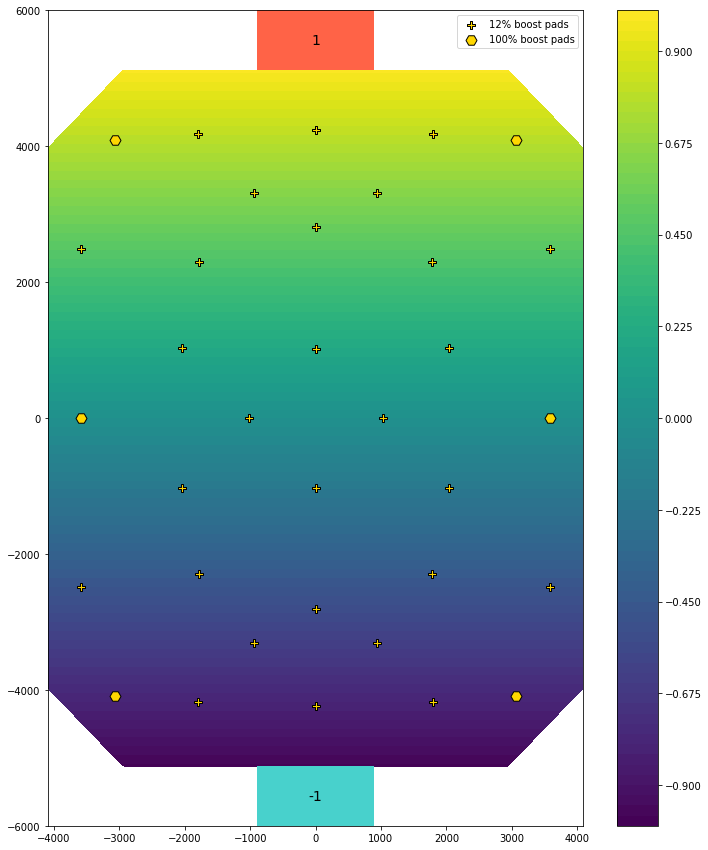

In [5]:
ball_zs = common.ball_goal.ball_y_coord(arena_positions)
plotting.arena_contour(ball_zs)

#### Ball to goal velocity

You can play around with the values of ball linear velocity. First axis is the x axis (side to side), second is y (goal to goal), third is z (up/down).

**_Note_**: ball maximum linear velocity is 6000, any more is not reflective of the true reward.

In [6]:
ball_lin_velocity = np.array([0, 5999, -40], dtype=float)
ball_lin_velocity_vec_len = np.linalg.norm(ball_lin_velocity).item()
print("Ball linear velocity vector length is " + str(ball_lin_velocity_vec_len))
assert ball_lin_velocity_vec_len <= common_values.BALL_MAX_SPEED, "Max ball linear velocity vector length must be less than or equal to 6000"

Ball linear velocity vector length is 5999.13335407707


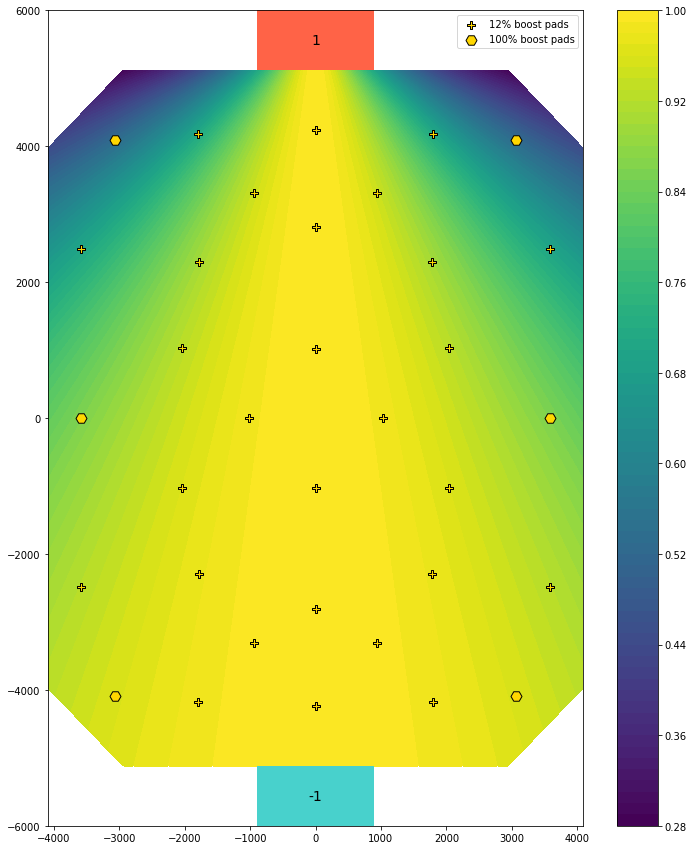

In [7]:
ball_zs = common.ball_goal.velocity_ball2goal(arena_positions, ball_lin_velocity)
plotting.arena_contour(ball_zs)

### Conditional

### Misc

### Player2ball

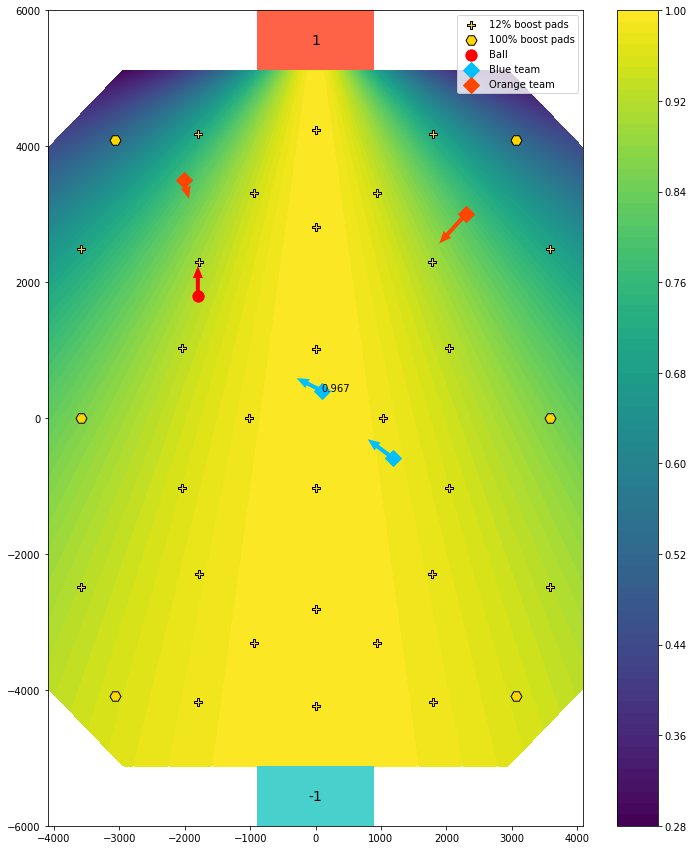

In [10]:
ball_position = np.array([-1800, 1800, 400])
ball_lin_velocity = np.array([0, 5999, -40], dtype=float)

# player_positions = np.array([[100, 400, 200]])
# player_lin_vels = np.array([[-1200, 600, 0]])

# player_positions = np.array([[100, 400, 200], [1200, -600, 300]])
# player_lin_vels = np.array([[-1200, 600, 0],[-1200, 900, 0]])

blue_positions = np.array([[100, 400, 200], [1200, -600, 300]])
orange_positions = np.array([[-2000, 3500, 250], [2300, 3000, 50]])
player_positions = (blue_positions, orange_positions)
blue_lin_vels = np.array([[-1200, 600, 0],[-1200, 900, 0]])
orange_lin_vels = np.array([[200, -700, 150],[-1000, -1100, 400]])
player_lin_vels = (blue_lin_vels, orange_lin_vels)

plotting.arena_contour(ball_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       player_positions=player_positions,
                       player_lin_vels=player_lin_vels
                       )